<a href="https://colab.research.google.com/github/JoshuaNalla/SNN-with-IFA/blob/main/DFA_version_of_Snn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Import core libraries
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# for evaluation purposes, importing scikit.metric
from sklearn.metrics import confusion_matrix

In [2]:
# def compute_weight_stats(num_neurons, v_mean=8.0, v_second_moment=164.0, alpha=0.066):
#     """
#     Compute weight initialization statistics.
#     Paper reference: Appendix C, Equations A.7 and A.8

#     Args:
#         num_neurons: Number of neurons in layer (N)
#         v_mean: Mean input value (v̄)
#         v_second_moment: Second moment of input (v̄̄)
#         alpha: Constant (0.066)

#     Returns:
#         w_mean: Mean weight value (W̄_n)
#         w_std: Standard deviation (σ_{W_n})
#     """
#     # Equation A.7: W̄_n = (v̄ - 0.8) / (α · N · v̄)
#     w_mean = (v_mean - 0.8) / (alpha * num_neurons * v_mean)

#     # Equation A.8: W̄̄_n for computing standard deviation
#     numerator = (v_second_moment +
#                  alpha**2 * (num_neurons - num_neurons**2) * w_mean**2 * v_mean**2 -
#                  1.6 * alpha * num_neurons * v_mean * w_mean -
#                  0.64)
#     denominator = alpha**2 * num_neurons * v_second_moment

#     w_second_moment = numerator / denominator

#     # Calculate standard deviation from second moment
#     w_std = np.sqrt(w_second_moment - w_mean**2)

#     return w_mean, w_std


# def initialize_feedback_matrix(output_shape, input_shape,
#                                 w_mean_next, w_std_next,
#                                 gamma=0.1,
#                                 num_downstream_layers=1):
#     """
#     Initialize fixed random feedback matrix B.
#     Paper reference: Appendix B, Equation A.5

#     Args:
#         output_shape: Number of neurons this layer projects to
#         input_shape: Number of neurons in this layer
#         w_mean_next: Mean of weights in next layer
#         w_std_next: Std of weights in next layer
#         gamma: Scale factor (0.0338 in paper) but using other values
#         num_downstream_layers: Number of layers between this and output (D)

#     Returns:
#         B: Fixed random feedback matrix [input_shape, output_shape]
#     """
#     # Generate random matrix with paper's specific distribution
#     # B_n = γ · [W̄_{n+1} + 2√3 · σ_{W_{n+1}} · (rand - 0.5)]

#     rand_values = np.random.uniform(0, 1, size=(input_shape, output_shape))

#     # Apply paper's formula
#     B = w_mean_next + 2 * np.sqrt(3) * w_std_next * (rand_values - 0.5)

#     # Apply scaling factor
#     B = gamma * B

#     # Note: Paper mentions product over downstream layers (∏)
#     # For simplicity with 2-layer network, we use single multiplication
#     # For deeper networks, you'd multiply B matrices from all downstream layers

#     return B.astype(np.float32)




In [3]:
class DFA_LIFLayer(nn.Module):
    """
    LIF layer that outputs spikes over time.
    Has fixed random feedback matrix B for DFA training.
    """
    def __init__(self, in_features, units, output_size,
                 tau=20.0, dt=0.25, threshold=0.1, t_ref=1.0,
                 use_dfa=True, gamma=0.0338):
        super().__init__()
        self.in_features = in_features
        self.units = units
        self.output_size = output_size

        self.tau = tau
        self.dt = dt
        self.threshold = threshold
        self.t_ref = t_ref
        self.use_dfa = use_dfa
        self.gamma = gamma

        # Trainable weights (like add_weight trainable=True)
        self.w = nn.Parameter(torch.empty(in_features, units))
        self.b = nn.Parameter(torch.zeros(units))
        nn.init.constant_(self.b, 0.2)

        # Init roughly like Keras Glorot-ish (you can match your stats init if you want)
        nn.init.xavier_uniform_(self.w)

        # Refractory steps
        self.ref_steps = int(round(self.t_ref / self.dt))

        # Fixed random feedback matrix B (like add_weight trainable=False)
        if use_dfa:
            B_init = torch.randn(units, output_size) * self.gamma
            self.register_buffer("B", B_init)  # NOT a Parameter -> not trainable

    def forward(self, inputs):
        """
        inputs: [batch, time, in_features]
        returns spikes: [batch, time, units]
        """
        batch_size, time_steps, _ = inputs.shape

        v = torch.zeros(batch_size, self.units, device=inputs.device)
        ref_count = torch.zeros(batch_size, self.units, device=inputs.device)

        spikes_out = []

        alpha = 1.0 - (self.dt / self.tau)
        beta  = self.dt / self.tau

        v_max = torch.tensor(0.0, device=inputs.device)
        v_mean_accum = 0.0

        for t in range(time_steps):
            x_t = inputs[:, t, :]

            I_t = (x_t @ self.w) + self.b
            v = alpha * v + beta * I_t
            # print once per forward call (you can comment this out after)

            # refractory
            v = torch.where(ref_count > 0, torch.zeros_like(v), v)

            # spike + reset
            spikes = (v >= self.threshold).float()

            v = v * (1.0 - spikes)

            # update refractory counter
            ref_count = ref_count - 1.0
            ref_count = torch.where(spikes > 0, torch.ones_like(ref_count) * self.ref_steps, ref_count)
            ref_count = torch.clamp(ref_count, min=0.0)

            spikes_out.append(spikes)


        return torch.stack(spikes_out, dim=1)

In [4]:
# @title
# math function (PyTorch version)

import torch
import numpy as np

def surrogate_gradient_exact(a, h_th=0.1, t_ref=1.0, tau=20.0): # original threshold was 0,4
    """
    Exact surrogate gradient from paper (Appendix D, Equation A.9).
    PyTorch version.
    """
    eps = 1e-8

    # Compute ratio a / (a - h_th)
    ratio = a / (a - h_th + eps)

    # Numerator: h_th * t_ref * tau / [a * (a - h_th)]
    numerator = h_th * t_ref * tau / (a * (a - h_th) + eps)

    # Denominator: [t_ref + tau * log(ratio)]^2
    log_term = torch.log(ratio + eps)
    denominator = (t_ref + tau * log_term) ** 2 + eps

    grad = numerator / denominator

    # Only non-zero where a > threshold
    grad = torch.where(a > h_th, grad, torch.zeros_like(grad))

    return grad


def surrogate_gradient_fast_sigmoid(a, threshold=0.1, alpha=5): # original threshold was 0,4
    """
    Fast sigmoid surrogate gradient (PyTorch version).
    """
    shifted = a - threshold
    grad = 1.0 / (1.0 + torch.abs(alpha * shifted)) ** 2
    return grad

In [5]:
# Cell A: PyTorch model (matches your Keras topology)
class DFASNN(nn.Module):
    def __init__(self, time_steps, input_size, hidden_size, hidden_size2, output_size):
        super().__init__()
        self.time_steps = time_steps

        # Hidden layer with DFA feedback matrix B
        self.hidden_layer = DFA_LIFLayer(
            in_features=input_size,
            units=hidden_size,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.08, # play with this (original was 0.4)
            t_ref=1.0,
            use_dfa=True,
            gamma=0.0338
        )

        # second hidden layer
        self.hidden_layer2 = DFA_LIFLayer(
            in_features=hidden_size,
            units=hidden_size2,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.05,
            t_ref=1.0,
            use_dfa=True,
            gamma=0.0338
        )


        # Output layer (no B matrix cus not trained)
        self.output_layer = DFA_LIFLayer(
            in_features=hidden_size2,
            units=output_size,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.2, # maybe play with this (original was 0.4)
            t_ref=1.0,
            use_dfa=False
        )

    def forward(self, x_time):
        """
        x_time: [batch, time, 784]  (matches your Keras input exactly)
        returns:
          h_spikes: [batch, time, hidden]
          h2_spikes: [batch, time, hidden]
          y_spikes: [batch, time, 10]
        """
        h_spikes = self.hidden_layer(x_time)
        h2_spikes = self.hidden_layer2(h_spikes)
        y_spikes = self.output_layer(h2_spikes)


        return h_spikes, h2_spikes, y_spikes

In [6]:
# Cell B: PyTorch DFA trainer (manual DFA updates, no autograd needed)
class DFATrainerTorch:
    def __init__(self, model, learning_rate=0.1, use_exact_gradient=True):
        self.model = model
        self.lr = learning_rate
        self.use_exact_gradient = use_exact_gradient

    @staticmethod
    def compute_spike_rate(spikes):
        # match your TF version: sum over time
        return spikes.sum(dim=1)  # [batch, units]

    def train_step(self, x_time, y_onehot):
      """
      x_time:   [b,t,784]
      y_onehot: [b,10]
      returns: (loss_float, acc_float)
      """
      self.model.train()
      x_time = x_time.to(device)
      y_onehot = y_onehot.to(device)

      # Forward
      h_spikes, h2_spikes, y_spikes = self.model(x_time)   # [b,t,H1], [b,t,H2], [b,t,10]
      out_rates = self.compute_spike_rate(y_spikes)        # [b,10]
      out_probs = F.softmax(out_rates, dim=1)              # [b,10]

      eps = 1e-9
      loss = -(y_onehot * torch.log(out_probs + eps)).sum(dim=1).mean()

      # Debug: spike activity
      # with torch.no_grad():
      #     print("mean h1 spike", h_spikes.mean().item(),
      #           "mean h2 spike", h2_spikes.mean().item(),
      #           "mean y spike",  y_spikes.mean().item())

      # Global error (broadcast to time)
      e_global = out_probs - y_onehot                      # [b,10]
      e_time = e_global.unsqueeze(1).repeat(1, y_spikes.size(1), 1)  # [b,t,10]

      bsz, T, _ = y_spikes.shape
      denom = float(bsz * T)

      with torch.no_grad():
          # =========================================================
          # 1) OUTPUT LAYER UPDATE (uses real output error)
          # =========================================================
          out_layer = self.model.output_layer
          out_input = h2_spikes                              # [b,t,H2]

          a_out = (out_input @ out_layer.w) + out_layer.b    # [b,t,10]

          if self.use_exact_gradient:
              fprime_out = surrogate_gradient_exact(
                  a_out, h_th=out_layer.threshold, t_ref=out_layer.t_ref, tau=out_layer.tau
              )
          else:
              fprime_out = surrogate_gradient_fast_sigmoid(
                  a_out, threshold=out_layer.threshold, alpha=10.0
              )

          e_out = e_time * fprime_out                        # [b,t,10]

          grad_w_out = torch.einsum("bti,btj->ij", out_input, e_out) / denom
          grad_b_out = e_out.sum(dim=(0, 1)) / denom

          out_layer.w -= self.lr * grad_w_out
          out_layer.b -= self.lr * grad_b_out

          # =========================================================
          # 2) HIDDEN LAYER 2 DFA UPDATE (projects output error via B2)
          # =========================================================
          hid2_layer = self.model.hidden_layer2

          # e_proj2: [b,t,10] x [H2,10] -> [b,t,H2]
          e_proj2 = torch.einsum("bto,ho->bth", e_time, hid2_layer.B)

          # pre-activation for hidden2 uses input = h_spikes (layer1 spikes)
          a_hid2 = (h_spikes @ hid2_layer.w) + hid2_layer.b  # [b,t,H2]

          if self.use_exact_gradient:
              fprime_hid2 = surrogate_gradient_exact(
                  a_hid2, h_th=hid2_layer.threshold, t_ref=hid2_layer.t_ref, tau=hid2_layer.tau
              )
          else:
              fprime_hid2 = surrogate_gradient_fast_sigmoid(
                  a_hid2, threshold=hid2_layer.threshold, alpha=10.0
              )

          e_hid2 = e_proj2 * fprime_hid2                     # [b,t,H2]

          grad_w_hid2 = torch.einsum("bti,btj->ij", h_spikes, e_hid2) / denom
          grad_b_hid2 = e_hid2.sum(dim=(0, 1)) / denom

          hid2_layer.w -= self.lr * grad_w_hid2
          hid2_layer.b -= self.lr * grad_b_hid2

          # =========================================================
          # 3) HIDDEN LAYER 1 DFA UPDATE (projects output error via B1)
          # =========================================================
          hid1_layer = self.model.hidden_layer

          # e_proj1: [b,t,10] x [H1,10] -> [b,t,H1]
          e_proj1 = torch.einsum("bto,ho->bth", e_time, hid1_layer.B)

          a_hid1 = (x_time @ hid1_layer.w) + hid1_layer.b    # [b,t,H1]

          if self.use_exact_gradient:
              fprime_hid1 = surrogate_gradient_exact(
                  a_hid1, h_th=hid1_layer.threshold, t_ref=hid1_layer.t_ref, tau=hid1_layer.tau
              )
          else:
              fprime_hid1 = surrogate_gradient_fast_sigmoid(
                  a_hid1, threshold=hid1_layer.threshold, alpha=10.0
              )

          e_hid1 = e_proj1 * fprime_hid1                     # [b,t,H1]

          grad_w_hid1 = torch.einsum("bti,btj->ij", x_time, e_hid1) / denom
          grad_b_hid1 = e_hid1.sum(dim=(0, 1)) / denom

          hid1_layer.w -= self.lr * grad_w_hid1
          hid1_layer.b -= self.lr * grad_b_hid1

        # Accuracy
      preds = torch.argmax(out_probs, dim=1)
      true = torch.argmax(y_onehot, dim=1)
      acc = (preds == true).float().mean().item()

      return loss.item(), acc

    def fit(self, x_time_all, y_onehot_all, epochs=20, batch_size=128, verbose=1):
      history = {"loss": [], "accuracy": []}
      n = x_time_all.shape[0]

      for ep in range(epochs):
          perm = torch.randperm(n)
          ep_loss = 0.0
          ep_acc = 0.0
          nb = 0

          for i in range(0, n, batch_size):
              idx = perm[i:i+batch_size]
              xb_time = x_time_all[idx].to(device)
              yb_onehot = y_onehot_all[idx].to(device)

              loss, acc = self.train_step(xb_time, yb_onehot)


              ep_loss += loss
              ep_acc += acc
              nb += 1

          history["loss"].append(ep_loss / nb)
          history["accuracy"].append(ep_acc / nb)

          if verbose:
              print(f"Epoch {ep+1}/{epochs} - loss: {history['loss'][-1]:.4f} - acc: {history['accuracy'][-1]:.4f}")

      return history

Training samples: 60000
Test samples: 10000
Input shape: 784
Output classes: 10

Input shape with time: (30000, 25, 784)
  [batch=30000, time=25, features=784]

BUILDING DFA-SNN MODEL (PyTorch)
DFASNN(
  (hidden_layer): DFA_LIFLayer()
  (hidden_layer2): DFA_LIFLayer()
  (output_layer): DFA_LIFLayer()
)

INITIALIZING DFA TRAINER (PyTorch)

DFA layers found: 3
  DFA_LIFLayer:
    Units: 1000
    B shape: (1000, 10)
    Learning rate: 0.100000
  DFA_LIFLayer:
    Units: 250
    B shape: (250, 10)
    Learning rate: 0.100000
  DFA_LIFLayer:
    Units: 10
    B shape: None
    Learning rate: 0.100000
Epoch 1/200 - loss: 2.3041 - acc: 0.0987
Epoch 2/200 - loss: 2.3153 - acc: 0.0989
Epoch 3/200 - loss: 2.3051 - acc: 0.0990
Epoch 4/200 - loss: 2.3034 - acc: 0.0930
Epoch 5/200 - loss: 2.2969 - acc: 0.0776
Epoch 6/200 - loss: 2.2788 - acc: 0.1115
Epoch 7/200 - loss: 2.2376 - acc: 0.1721
Epoch 8/200 - loss: 2.1929 - acc: 0.1995
Epoch 9/200 - loss: 2.1608 - acc: 0.2083
Epoch 10/200 - loss: 2.1061 

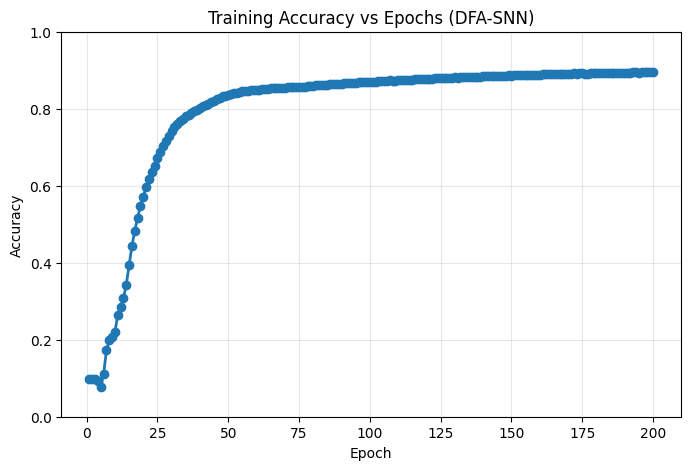

In [8]:
# @title
# PyTorch version of that ONE cell (data prep + build + train + plot)
# Assumes you already defined: DFA_LIFLayer, DFASNN, DFATrainerTorch (from earlier port steps)

import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# ----------------------------
# Load MNIST data (PyTorch)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),                  # -> float32 in [0,1], shape [1,28,28]
    transforms.Lambda(lambda x: x.view(-1))  # -> [784]
])

train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds_full  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convert to tensors (to mirror your "x_train, y_train" arrays)
# Note: this iterates through the dataset once; fine for MNIST.
x_train = torch.stack([train_ds_full[i][0] for i in range(len(train_ds_full))]).float()  # [60000,784]
y_train_int = torch.tensor([train_ds_full[i][1] for i in range(len(train_ds_full))], dtype=torch.long)  # [60000]

x_test  = torch.stack([test_ds_full[i][0] for i in range(len(test_ds_full))]).float()    # [10000,784]
y_test_int  = torch.tensor([test_ds_full[i][1] for i in range(len(test_ds_full))], dtype=torch.long)   # [10000]

# One-hot encode labels (to match your Keras cell exactly)
y_train = F.one_hot(y_train_int, num_classes=10).float()  # [60000,10]
y_test  = F.one_hot(y_test_int, num_classes=10).float()   # [10000,10]

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"Input shape: {x_train.shape[1]}")
print(f"Output classes: {y_train.shape[1]}")

TIME_STEPS = 25   # Reduced from 100 for faster training
HIDDEN_SIZE = 1000
HIDDEN_SIZE2 = 250
OUTPUT_SIZE = 10
INPUT_SIZE = 784

# INCREASED: Use larger dataset
TRAIN_SAMPLES = 30000
x_train_small = x_train[:TRAIN_SAMPLES]          # [30000,784]
y_train_small = y_train[:TRAIN_SAMPLES]          # [30000,10]
y_train_small_int = y_train_int[:TRAIN_SAMPLES]  # [30000]

# Expand to time dimension (paper uses "direct mapping")
# Just repeat the input for each time step
# (Matches your np.tile logic, but in torch)
x_train_spikes = x_train_small.unsqueeze(1).repeat(1, TIME_STEPS, 1)  # [30000,25,784]

print(f"\nInput shape with time: {tuple(x_train_spikes.shape)}")
print(f"  [batch={x_train_spikes.shape[0]}, "
      f"time={x_train_spikes.shape[1]}, "
      f"features={x_train_spikes.shape[2]}]")

# ----------------------------
# Build DFA-SNN model (PyTorch)
# ----------------------------
print("\n" + "="*60)
print("BUILDING DFA-SNN MODEL (PyTorch)")
print("="*60)

# Safety checks (so you get a clear error if earlier port cells aren't run yet)
missing = []
for name in ["DFA_LIFLayer", "DFASNN", "DFATrainerTorch"]:
    if name not in globals():
        missing.append(name)
if missing:
    raise NameError(
        "You haven't defined these yet in earlier cells: "
        + ", ".join(missing)
        + "\nRun the cells where you ported the layer/model/trainer first."
    )

model = DFASNN(
    time_steps=TIME_STEPS,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    hidden_size2=HIDDEN_SIZE2,
    output_size=OUTPUT_SIZE
).to(device)

with torch.no_grad():
        model.hidden_layer2.b.fill_(1.0)
        model.output_layer.b.fill_(1.0)
print(model)

# ----------------------------
# Create DFA trainer (PyTorch)
# ----------------------------
print("\n" + "="*60)
print("INITIALIZING DFA TRAINER (PyTorch)")
print("="*60)

trainer = DFATrainerTorch(
    model=model,
    learning_rate=0.1  # matches your cell
)

# Mirror your "dfa layers found" printout as closely as possible
dfa_layers = []
if hasattr(model, "hidden_layer"):
    dfa_layers.append(model.hidden_layer)
if hasattr(model, "hidden_layer2"):
    dfa_layers.append(model.hidden_layer2)
if hasattr(model, "output_layer"):
    dfa_layers.append(model.output_layer)

print(f"\nDFA layers found: {len(dfa_layers)}")
for layer in dfa_layers:
    B_shape = tuple(layer.B.shape) if hasattr(layer, "B") else None
    print(f"  {layer.__class__.__name__}:")
    print(f"    Units: {layer.units}")
    print(f"    B shape: {B_shape}")
    print(f"    Learning rate: {trainer.lr:.6f}")

model.hidden_layer.debug_name = "h1"
model.hidden_layer2.debug_name = "h2"
model.output_layer.debug_name = "out"




# We already built x_train_spikes as a full tensor [30000,25,784]
# To keep this as a single-cell replica, we’ll train on it directly in batches.

history = trainer.fit(x_train_spikes, y_train_small, epochs=200, batch_size=128, verbose=1)

import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(history["accuracy"]) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["accuracy"], marker='o', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Epochs (DFA-SNN)")
plt.grid(True, alpha=0.3)

plt.xticks(epochs if len(epochs) <= 20 else None)
plt.ylim(0, 1.0)

plt.show()
